In [42]:
import itertools
import time
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transformers
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [43]:
train_codes = pd.read_csv('train_embbeds.csv')
train_labels = pd.read_csv('train_labels.csv')
print(train_codes.shape)
print(train_labels.shape)

(53999, 1024)
(53999, 1)


In [44]:
train_set = train_codes.iloc[:,0:1024].values
train_set_labels= train_labels.iloc[:,:].values
print(train_set.shape)
print(train_set_labels.shape)

(53999, 1024)
(53999, 1)


In [45]:
test_codes = pd.read_csv('test_embbeds.csv')
test_labels = pd.read_csv('test_labels.csv')
print(test_codes.shape)
print(test_labels.shape)

(17999, 1024)
(17999, 1)


In [46]:
test_set = test_codes.iloc[:,0:1024].values
test_set_labels= test_labels.iloc[:,:].values
print(test_set.shape)
print(test_set_labels.shape)

(17999, 1024)
(17999, 1)


In [47]:
def sliding_windows(dataX,dataY, seq_length):
    print("shape of data: ", dataX.shape)
    print("shape of data labels: ", dataY.shape)
    print("seq_length: ", seq_length)
    
    #batch_len=len(dataX)
    
    #x = torch.empty((1,4,1024))
    # y = torch.empty((1,1))
    #y = torch.empty(1,1)
    
    x = []
    y = []
    
    for i in range(len(dataX)-seq_length-1):
        _x = dataX[i:(i+seq_length)]
        _y = dataY[i+seq_length]
        x.append(_x)
        y.append(_y)
    
    #for i in range(batch_len-seq_length-1):
        # _x = data.detach()[i:(i+seq_length)]
        # _y = data.detach()[i+seq_length]
        #_x = dataX[i:(i+seq_length)]
        #_y = dataY[i+seq_length]
        
        #_xOut=rearrange(_x,'w h -> 1 w h')
        #_yOut=rearrange(_y,'w -> 1 w')


        #x = torch.cat((x, _xOut),dim=0)
        #y = torch.cat((y, _yOut),dim=0)

    # return torch.tensor(x),torch.tensor(y)
    #print("Size of x: ", x.size())
    #print("Size of _x: ", _x.size())
    #print("Size of y: ", y.size())
    #print("Size of _y: ", _y.size())
    
    x_array=np.array(x)
    y_array=np.array(y)
    
    return torch.tensor(x_array), torch.tensor(y_array)

In [151]:
seq_length = 5
x_train, y_train = sliding_windows(train_set, train_set_labels, seq_length)

print("The shape of x_train: ", x_train.size())
print("The shape of y_train: ", y_train.size())

x_train=x_train.float()
y_train=y_train.float()

shape of data:  (53999, 1024)
shape of data labels:  (53999, 1)
seq_length:  5
The shape of x_train:  torch.Size([53993, 5, 1024])
The shape of y_train:  torch.Size([53993, 1])


In [152]:
seq_length = 5
x_test, y_test = sliding_windows(test_set, test_set_labels, seq_length)

print("The shape of x_train: ", x_test.size())
print("The shape of y_train: ", y_test.size())

x_test=x_test.float()
y_test=y_test.float() 

shape of data:  (17999, 1024)
shape of data labels:  (17999, 1)
seq_length:  5
The shape of x_train:  torch.Size([17993, 5, 1024])
The shape of y_train:  torch.Size([17993, 1])


In [50]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [51]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [52]:
#trainX = Variable(x_train)
#trainY = Variable(y_train)
    
#print("Shape of trainX: ", trainX.size())
#print("Shape of trainY: ", trainY.size())

In [53]:
#testX = Variable(x_test)
#testY = Variable(y_test)
    
#print("Shape of trainX: ", testX.size())
#print("Shape of trainY: ", testY.size())

In [153]:
batch_size=8192

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [399]:
#num_epochs = 10
learning_rate = 0.00034

input_size = 1024
hidden_size = 512
num_layers = 1

num_classes = 1

# locate our GPU device and initialize it for training
#use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
#device = torch.device('cpu')

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, device)
lstm.to(device)
print("Number of parameters: ", sum(p.numel() for p in lstm.parameters()))

criterion = torch.nn.MSELoss()    # mean-sqaured error for regression
#criterion = nn.modules.loss.BCEWithLogitsLoss()    # mean-sqaured error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
#for epoch in range(num_epochs):
    
    #Run a train on the train sequence
#    lstm.train()
#    outputs = lstm(trainX.to(device))
#    optimizer.zero_grad()
#    loss = criterion(outputs, trainY.to(device))
#    loss.backward()
#    optimizer.step()
    
    #Evaluate the epoch on the test sequence.
#    lstm.eval()
#    test_outputs = lstm(testX.to(device))
#    test_loss = criterion(test_outputs, testY.to(device))
    
#    if epoch % 2 == 0:
#      print(f'Epoch {epoch}, Loss_train: {loss:.4f}, Loss_test: {test_loss:.4f}')

Number of parameters:  3150337


In [187]:
def training(model, criterion, optimizer, train_loader, test_loader, epochs):
    # start a clock 
    start_time = time.time()
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        batch_train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        batch_test_loss = []
        for test_inputs, test_targets in test_loader:
            test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)  # Move test inputs and targets to the GPU
            test_outputs = model(test_inputs)
            loss = criterion(test_outputs, test_targets)
            batch_test_loss.append(loss.item())

        train_loss = np.mean(batch_train_loss)
        test_loss = np.mean(batch_test_loss)

        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if (it + 1) % 10 == 0:
            print(f'Epoch {it + 1}/{epochs}, Loss_train: {train_loss:.4f}, Loss_test: {test_loss:.4f}')
            
    end_time = time.time()
    train_time = end_time - start_time
    print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
    print('Finished Training')

    return train_losses, test_losses

Epoch 5/200, Loss_train: 0.0304, Loss_test: 0.0212
Epoch 10/200, Loss_train: 0.0090, Loss_test: 0.0085
Epoch 15/200, Loss_train: 0.0063, Loss_test: 0.0068
Epoch 20/200, Loss_train: 0.0050, Loss_test: 0.0060
Epoch 25/200, Loss_train: 0.0041, Loss_test: 0.0054
Epoch 30/200, Loss_train: 0.0034, Loss_test: 0.0050
Epoch 35/200, Loss_train: 0.0030, Loss_test: 0.0047
Epoch 40/200, Loss_train: 0.0026, Loss_test: 0.0045
Epoch 45/200, Loss_train: 0.0023, Loss_test: 0.0043
Epoch 50/200, Loss_train: 0.0020, Loss_test: 0.0041
Epoch 55/200, Loss_train: 0.0018, Loss_test: 0.0040
Epoch 60/200, Loss_train: 0.0016, Loss_test: 0.0039
Epoch 65/200, Loss_train: 0.0015, Loss_test: 0.0038
Epoch 70/200, Loss_train: 0.0014, Loss_test: 0.0037
Epoch 75/200, Loss_train: 0.0012, Loss_test: 0.0036
Epoch 80/200, Loss_train: 0.0011, Loss_test: 0.0035
Epoch 85/200, Loss_train: 0.0010, Loss_test: 0.0035
Epoch 90/200, Loss_train: 0.0010, Loss_test: 0.0034
Epoch 95/200, Loss_train: 0.0009, Loss_test: 0.0034
Epoch 100/200

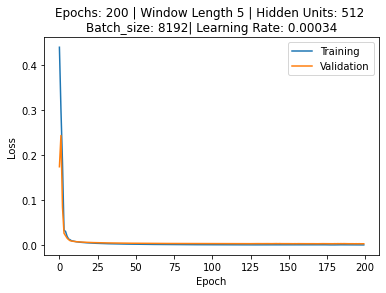

In [400]:
epochs=200
train_losses, test_losses = training(lstm, criterion, optimizer, train_loader, test_loader, epochs)

loss_title = "Epochs: " + str(epochs) + " | Window Length " + str(seq_length) +" | Hidden Units: " + str(hidden_size) + " \nBatch_size: " + str(batch_size) + "| Learning Rate: " + str(learning_rate)
plt.title(loss_title)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plt.yscale("log")
plt.plot(train_losses, label= "Training")
plt.plot(test_losses, label = "Validation")
plt.legend()


figname = "e"+str(epochs)+"bs"+str(batch_size)+"lr"+str(learning_rate)+".png"
#print(figname)
#plt.savefig(figname)

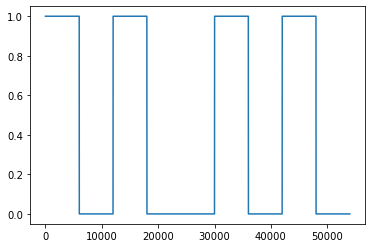

In [362]:
plt.plot(y_train)

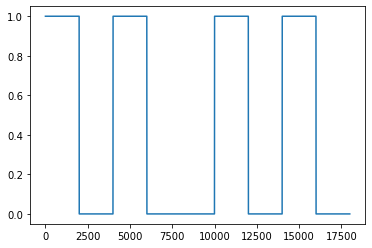

In [363]:
plt.plot(y_test)

In [401]:
lstm.to(device)
lstm.eval()

test_return=np.empty(1)


for test_inputs, test_targets in test_loader:
    test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)  # Move test inputs and targets to the GPU
    test_outputs = lstm(test_inputs)
    test_return=np.append(test_return,test_outputs.to('cpu').detach().numpy())

In [402]:
print(test_return.shape)

(17994,)


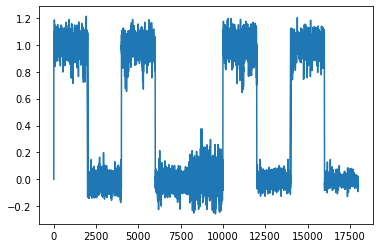

In [403]:
plt.plot(test_return)

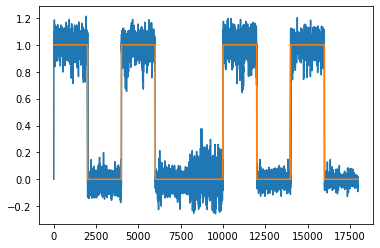

In [404]:
plt.plot(test_return)
plt.plot(y_test)

In [405]:
clamped_test=np.empty(len(test_return))
for i in range(len(test_return)):
    if test_return[i]>0.5:
        clamped_test[i]=1
    else:
        clamped_test[i]=0

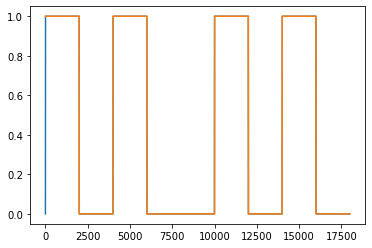

In [406]:
plt.plot(clamped_test)
plt.plot(y_test)

In [407]:
#df_output = pd.DataFrame(clamped_test)
#df_label2 = pd.DataFrame(y_test_array)
#df_output.to_csv('test_ouputs.csv', mode='a', index=False, header=False)
#df_label.to_csv('test_labels3.csv', mode='a', index=False, header=False)

In [408]:
y_test_array=y_test.detach().numpy()

In [409]:
y_test_array_t=np.transpose(y_test_array)

In [410]:
print(y_test_array_t.shape)

(1, 17993)


In [411]:
print(clamped_test.shape)

(17994,)


In [422]:
clamped_test_rs=np.resize(clamped_test[1:17994],(1,17993))

In [423]:
clamped_test_rs.shape

(1, 17993)

In [424]:
mse = (np.square(clamped_test_rs - y_test_array_t).mean(axis=0))

In [425]:
print(mse)

[0. 0. 0. ... 0. 0. 0.]


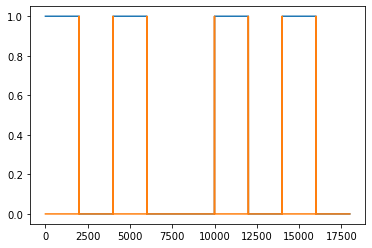

In [426]:
plt.plot(y_test)
plt.plot(mse)

In [160]:
valid_codes = pd.read_csv('valid_embbeds.csv')
valid_labels = pd.read_csv('valid_labels.csv')
print(valid_codes.shape)
print(valid_labels.shape)

(8999, 1024)
(8999, 1)


In [161]:
valid_set = valid_codes.iloc[:,0:1024].values
valid_set_labels= valid_labels.iloc[:,:].values
print(valid_set.shape)
print(valid_set_labels.shape)

(8999, 1024)
(8999, 1)


In [252]:
x_valid, y_valid = sliding_windows(valid_set, valid_set_labels, seq_length)

print("The shape of x_valid: ", x_valid.size())
print("The shape of y_valid: ", y_valid.size())

x_valid=x_valid.float()
y_valid=y_valid.float()

shape of data:  (8999, 1024)
shape of data labels:  (8999, 1)
seq_length:  5
The shape of x_valid:  torch.Size([8993, 5, 1024])
The shape of y_valid:  torch.Size([8993, 1])


In [253]:
valid_dataset = torch.utils.data.TensorDataset(x_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

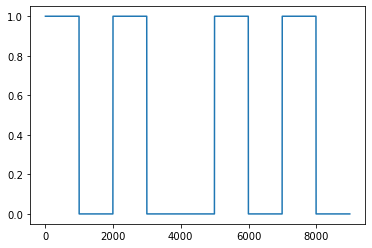

In [254]:
plt.plot(y_valid)

In [255]:
lstm.to(device)
lstm.eval()

valid_return=np.empty(1)


for valid_inputs, valid_targets in valid_loader:
    valid_inputs, valid_targets = valid_inputs.to(device), valid_targets.to(device)  # Move test inputs and targets to the GPU
    valid_outputs = lstm(valid_inputs)
    valid_return=np.append(valid_return,valid_outputs.to('cpu').detach().numpy())

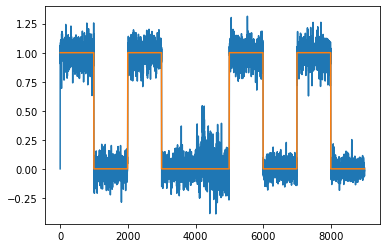

In [256]:
plt.plot(valid_return)
plt.plot(y_valid)

In [257]:
valid_norm=(valid_return-np.min(valid_return))/(np.max(valid_return)-np.min(valid_return))

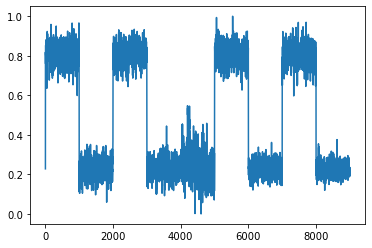

In [258]:
plt.plot(valid_norm)

In [259]:
print(len(valid_return))

8994


In [260]:
print(valid_return[2])

0.965334951877594


In [261]:
clamped_valid=np.empty(len(valid_return))
for i in range(len(valid_return)):
    if valid_return[i]>0.5:
        clamped_valid[i]=1
    else:
        clamped_valid[i]=0

In [262]:
print(len(clamped_valid))

8994


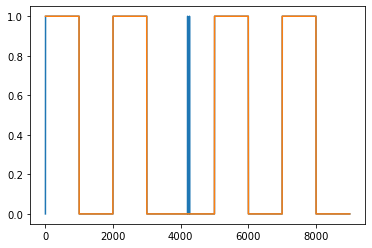

In [263]:
plt.plot(clamped_valid)
plt.plot(y_valid)

In [265]:
y_valid_array=y_valid.detach().numpy()

In [267]:
y_valid_array_t=np.transpose(y_valid_array)

In [269]:
print(y_valid_array_t.shape)

(1, 8993)


In [301]:
clamped_valid_rs=np.resize(clamped_valid[1:8994],(1,8993))

In [302]:
print(clamped_valid_rs.shape)

(1, 8993)


In [299]:
mse_v = (np.square(clamped_valid_rs - y_valid_array_t).mean(axis=0))
print(mse_v)

[0. 0. 0. ... 0. 0. 0.]


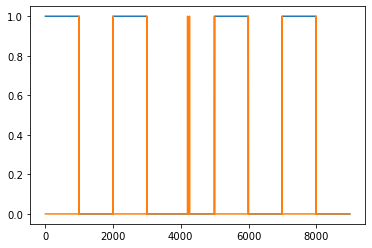

In [300]:
plt.plot(y_valid)
plt.plot(mse_v)